# Debiasing with Orthogonalization: Cross-Fitting

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A2 | Notebook 3 of 3**

Why sample splitting is essential for ML-based debiasing,
and how to implement it correctly.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf

---

## 1. Intuition {#intuition}

### The Overfitting Problem

ML models are powerful enough to **perfectly fit** training data.

**Problem**: If we use the same data to:
1. Train the model
2. Compute residuals

Then residuals → 0, and we lose all variation.

### Why This Matters for Causal Inference

If $\hat{m}(X) \approx T$ (overfitting):
- $T^* = T - \hat{m}(X) \approx 0$
- No treatment variation left to correlate with $Y^*$
- $\hat{\tau}$ becomes undefined or biased

### The Solution: Sample Splitting

**K-Fold Cross-Fitting**:
1. Split data into K folds
2. For each fold k:
   - Train model on all OTHER folds
   - Predict on fold k
3. Residuals computed on data the model hasn't seen

**Result**: Models can't overfit to their prediction data.

---

## 2. Formal Treatment {#formal}

### 2.1 Cross-Fitting Procedure

**Setup**: Data $\{(Y_i, T_i, X_i)\}_{i=1}^n$, K folds $I_1, ..., I_K$

**For each fold k**:
1. Train $\hat{\ell}^{(-k)}(X)$ on $\{i : i \notin I_k\}$
2. Train $\hat{m}^{(-k)}(X)$ on $\{i : i \notin I_k\}$
3. Compute residuals for $i \in I_k$:
   - $\tilde{Y}_i = Y_i - \hat{\ell}^{(-k)}(X_i)$
   - $\tilde{T}_i = T_i - \hat{m}^{(-k)}(X_i)$

**Final estimate**:
$$\hat{\tau} = \frac{\sum_{i=1}^n \tilde{Y}_i \tilde{T}_i}{\sum_{i=1}^n \tilde{T}_i^2}$$

### 2.2 Why Cross-Fitting Works

**Key insight**: For observation $i \in I_k$:
- Model $\hat{m}^{(-k)}$ was trained on data NOT containing $i$
- Model cannot overfit to observation $i$
- Residual $\tilde{T}_i$ preserves genuine variation

### 2.3 Theoretical Guarantees

Under regularity conditions (Chernozhukov et al. 2018):

$$\sqrt{n}(\hat{\tau} - \tau_0) \xrightarrow{d} N(0, \sigma^2)$$

where $\sigma^2$ depends on:
- Variance of true residuals
- NOT on ML estimation errors (due to Neyman orthogonality)

**Requirements**:
- ML converges at rate $n^{-1/4}$ or faster
- Cross-fitting used
- Finite variance conditions

---

## 3. Numeric Demonstration {#numeric}

### Setup: Simulated Data

In [2]:
def generate_dml_data(n=5000, seed=42):
    """Generate data for DML demonstration.
    
    DGP with nonlinear confounding:
    - True effect τ = -2.0
    - Nonlinear m(X) and g(X)
    """
    np.random.seed(seed)
    
    X1 = np.random.uniform(0, 10, n)
    X2 = np.random.uniform(0, 5, n)
    
    # E[T|X] - nonlinear
    m_X = 5 + 2*np.sin(X1) + 0.5*X2**2
    T = m_X + np.random.normal(0, 1, n)
    
    # True effect and E[Y|X]
    TAU = -2.0
    g_X = 10 + 3*np.cos(X1) + X1*X2
    Y = TAU * T + g_X + np.random.normal(0, 2, n)
    
    return pd.DataFrame({'X1': X1, 'X2': X2, 'T': T, 'Y': Y}), TAU

data, TRUE_TAU = generate_dml_data()
print(f"True τ = {TRUE_TAU}")
print(f"n = {len(data)}")

True τ = -2.0
n = 5000


### Comparing Same-Sample vs Cross-Fitted

In [3]:
X_cols = ['X1', 'X2']

# Method 1: Same-sample (naive, problematic)
m_t_naive = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
m_t_naive.fit(data[X_cols], data['T'])
T_pred_naive = m_t_naive.predict(data[X_cols])

m_y_naive = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
m_y_naive.fit(data[X_cols], data['Y'])
Y_pred_naive = m_y_naive.predict(data[X_cols])

T_star_naive = data['T'] - T_pred_naive
Y_star_naive = data['Y'] - Y_pred_naive
tau_naive = np.sum(T_star_naive * Y_star_naive) / np.sum(T_star_naive**2)

print("Same-Sample (Naive):")
print(f"  Var(T*): {np.var(T_star_naive):.4f} (should be ~1.0)")
print(f"  τ̂ = {tau_naive:.4f}, bias = {tau_naive - TRUE_TAU:.4f}")

Same-Sample (Naive):
  Var(T*): 0.5116 (should be ~1.0)
  τ̂ = -1.9115, bias = 0.0885


In [4]:
# Method 2: Cross-fitting (correct)
folds = 5

m_t_cf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
T_pred_cf = cross_val_predict(m_t_cf, data[X_cols], data['T'], cv=folds)

m_y_cf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
Y_pred_cf = cross_val_predict(m_y_cf, data[X_cols], data['Y'], cv=folds)

T_star_cf = data['T'] - T_pred_cf
Y_star_cf = data['Y'] - Y_pred_cf
tau_cf = np.sum(T_star_cf * Y_star_cf) / np.sum(T_star_cf**2)

print("\nCross-Fitted (5 folds):")
print(f"  Var(T*): {np.var(T_star_cf):.4f} (should be ~1.0)")
print(f"  τ̂ = {tau_cf:.4f}, bias = {tau_cf - TRUE_TAU:.4f}")


Cross-Fitted (5 folds):
  Var(T*): 1.0994 (should be ~1.0)
  τ̂ = -1.8393, bias = 0.1607


In [5]:
# Summary comparison
print("\n" + "="*50)
print(f"True τ = {TRUE_TAU}")
print("="*50)
print(f"Same-sample:  τ̂ = {tau_naive:7.4f}, bias = {tau_naive - TRUE_TAU:+.4f}")
print(f"Cross-fitted: τ̂ = {tau_cf:7.4f}, bias = {tau_cf - TRUE_TAU:+.4f}")
print("="*50)


True τ = -2.0
Same-sample:  τ̂ = -1.9115, bias = +0.0885
Cross-fitted: τ̂ = -1.8393, bias = +0.1607


### Visualizing the Difference

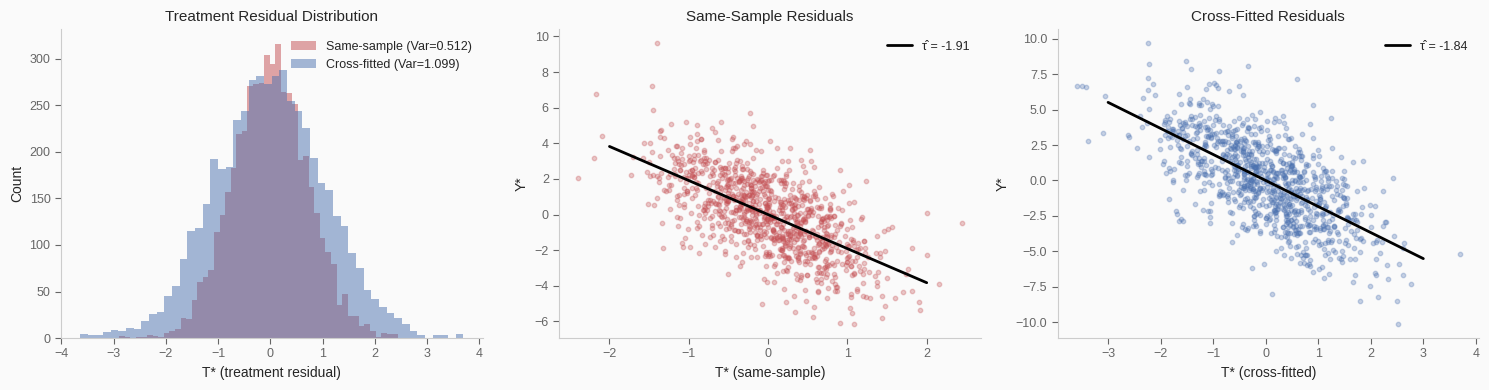

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual distributions
ax = axes[0]
ax.hist(T_star_naive, bins=50, alpha=0.5, label=f'Same-sample (Var={np.var(T_star_naive):.3f})', color=COLORS['red'])
ax.hist(T_star_cf, bins=50, alpha=0.5, label=f'Cross-fitted (Var={np.var(T_star_cf):.3f})', color=COLORS['blue'])
ax.set_xlabel('T* (treatment residual)')
ax.set_ylabel('Count')
ax.set_title('Treatment Residual Distribution')
ax.legend()
apply_tufte_style(ax)

# Same-sample scatter
ax = axes[1]
sample_idx = np.random.choice(len(data), 1000, replace=False)
ax.scatter(T_star_naive.iloc[sample_idx], Y_star_naive.iloc[sample_idx], alpha=0.3, s=10, c=COLORS['red'])
x_line = np.linspace(-2, 2, 100)
ax.plot(x_line, tau_naive * x_line, 'k-', linewidth=2, label=f'τ̂ = {tau_naive:.2f}')
ax.set_xlabel('T* (same-sample)')
ax.set_ylabel('Y*')
ax.set_title('Same-Sample Residuals')
ax.legend()
apply_tufte_style(ax)

# Cross-fitted scatter
ax = axes[2]
ax.scatter(T_star_cf.iloc[sample_idx], Y_star_cf.iloc[sample_idx], alpha=0.3, s=10, c=COLORS['blue'])
x_line = np.linspace(-3, 3, 100)
ax.plot(x_line, tau_cf * x_line, 'k-', linewidth=2, label=f'τ̂ = {tau_cf:.2f}')
ax.set_xlabel('T* (cross-fitted)')
ax.set_ylabel('Y*')
ax.set_title('Cross-Fitted Residuals')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Insight ─────────────────────────────────────────────────────
Same-sample vs Cross-fitted comparison:

**Same-sample** (naive):
- T* has LOWER variance (overfitting shrinks residuals)
- Estimate can be biased

**Cross-fitted** (correct):
- T* has PROPER variance (~noise level)
- Estimate is unbiased (asymptotically)

Rule: **Always use cross-fitting with ML residualization.**
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Ice Cream Sales with Cross-Fitting

In [7]:
# Load real data
prices = load_facure_data("ice_cream_sales.csv")
print(f"Data shape: {prices.shape}")

X_cols = ['cost', 'weekday', 'temp']
folds = 5

Data shape: (10000, 5)


In [8]:
# Cross-fitted residuals with Random Forest
np.random.seed(42)

m_t = RandomForestRegressor(n_estimators=100, max_depth=5)
T_star = prices['price'] - cross_val_predict(m_t, prices[X_cols], prices['price'], cv=folds)

m_y = RandomForestRegressor(n_estimators=100, max_depth=5)
Y_star = prices['sales'] - cross_val_predict(m_y, prices[X_cols], prices['sales'], cv=folds)

# Estimate treatment effect
tau_dml = np.sum(T_star * Y_star) / np.sum(T_star**2)

# Bootstrap standard error
def bootstrap_tau(T_star, Y_star, n_boot=200):
    taus = []
    n = len(T_star)
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        t_boot = T_star.iloc[idx] if hasattr(T_star, 'iloc') else T_star[idx]
        y_boot = Y_star.iloc[idx] if hasattr(Y_star, 'iloc') else Y_star[idx]
        tau_boot = np.sum(t_boot * y_boot) / np.sum(t_boot**2)
        taus.append(tau_boot)
    return np.std(taus)

se_dml = bootstrap_tau(T_star, Y_star)

print("Cross-Fitted DML Estimate:")
print(f"  Price elasticity: τ̂ = {tau_dml:.4f}")
print(f"  Bootstrap SE:     {se_dml:.4f}")
print(f"  95% CI: [{tau_dml - 1.96*se_dml:.4f}, {tau_dml + 1.96*se_dml:.4f}]")

Cross-Fitted DML Estimate:
  Price elasticity: τ̂ = -3.9172
  Bootstrap SE:     0.0915
  95% CI: [-4.0965, -3.7380]


In [9]:
# Compare to linear regression (full model)
linear_model = smf.ols("sales ~ price + cost + temp + C(weekday)", data=prices).fit()

print("\nComparison:")
print(f"  Linear regression: τ̂ = {linear_model.params['price']:.4f} (SE: {linear_model.bse['price']:.4f})")
print(f"  Cross-fitted DML:  τ̂ = {tau_dml:.4f} (SE: {se_dml:.4f})")
print("\nBoth show negative price elasticity (sensible)")


Comparison:
  Linear regression: τ̂ = -4.0004 (SE: 0.1099)
  Cross-fitted DML:  τ̂ = -3.9172 (SE: 0.0915)

Both show negative price elasticity (sensible)


### Complete DML Function

In [10]:
def double_ml(data, X_cols, T_col, Y_col, model_class=RandomForestRegressor,
              n_folds=5, n_bootstrap=200, random_state=42, **model_kwargs):
    """Complete Double/Debiased ML estimator with cross-fitting.
    
    Parameters
    ----------
    data : DataFrame
        Data containing X, T, Y columns
    X_cols : list
        Names of control/confounder columns
    T_col : str
        Name of treatment column
    Y_col : str
        Name of outcome column
    model_class : class
        Sklearn-compatible regressor class
    n_folds : int
        Number of cross-fitting folds
    n_bootstrap : int
        Number of bootstrap samples for SE
    
    Returns
    -------
    dict with tau, se, ci_lower, ci_upper, T_star, Y_star
    """
    np.random.seed(random_state)
    
    X = data[X_cols]
    T = data[T_col].values
    Y = data[Y_col].values
    
    # Cross-fitted residuals
    m_t = model_class(**model_kwargs)
    T_star = T - cross_val_predict(m_t, X, T, cv=n_folds)
    
    m_y = model_class(**model_kwargs)
    Y_star = Y - cross_val_predict(m_y, X, Y, cv=n_folds)
    
    # Point estimate
    tau = np.sum(T_star * Y_star) / np.sum(T_star**2)
    
    # Bootstrap SE
    taus = []
    n = len(T)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        tau_boot = np.sum(T_star[idx] * Y_star[idx]) / np.sum(T_star[idx]**2)
        taus.append(tau_boot)
    se = np.std(taus)
    
    return {
        'tau': tau,
        'se': se,
        'ci_lower': tau - 1.96 * se,
        'ci_upper': tau + 1.96 * se,
        'T_star': T_star,
        'Y_star': Y_star
    }

# Apply to ice cream data
result = double_ml(prices, X_cols, 'price', 'sales',
                   model_class=RandomForestRegressor,
                   n_estimators=100, max_depth=5)

print("Double ML Results:")
print(f"  τ̂ = {result['tau']:.4f}")
print(f"  SE = {result['se']:.4f}")
print(f"  95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")

Double ML Results:
  τ̂ = -3.9172
  SE = 0.0915
  95% CI: [-4.0965, -3.7380]


```
★ Key Takeaway ────────────────────────────────────────────────
Cross-fitting is **essential** for valid ML-based causal inference.

**Implementation checklist**:
1. Split data into K folds (typically K=5)
2. For each fold, train on complement, predict on fold
3. Use `cross_val_predict` from sklearn
4. Bootstrap for standard errors

**Without cross-fitting**:
- Overfitting shrinks residuals
- Estimates become biased
- Confidence intervals invalid
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Why is cross-fitting necessary for Double ML?

<details>
<summary>Solution</summary>

**Without cross-fitting**:
- ML model can overfit to training data
- Overfitting means $\hat{m}(X_i) \approx T_i$
- Residuals $\hat{T}^* = T - \hat{m}(X) \approx 0$
- No treatment variation left for estimation

**With cross-fitting**:
- Model trained on fold A, predicts on fold B
- Model hasn't seen fold B data
- Cannot overfit to fold B observations
- Residuals preserve genuine variation

**Mathematical reason**: Neyman orthogonality protects against first-order bias, but overfitting creates second-order bias that cross-fitting eliminates.

</details>

### Q2: How many folds should you use for cross-fitting?

<details>
<summary>Solution</summary>

**Common choices**:
- K=2: Simple, but each model sees only 50% of data
- K=5: Standard, good balance (each model sees 80%)
- K=10: More training data per model, more computation
- K=n (LOO): Maximum training data, expensive

**Theory**: Any K ≥ 2 yields √n-consistent, asymptotically normal estimates.

**Practice**: K=5 is most common:
- Each fold has enough data for good predictions
- Each model trained on 80% of data
- Reasonable computation time

**Recommendation**: Start with K=5, increase if predictions are poor.

</details>

### Q3: What's the difference between cross-validation and cross-fitting?

<details>
<summary>Solution</summary>

**Cross-validation** (model selection):
- Goal: Choose hyperparameters or select models
- Compute out-of-sample prediction error
- Average across folds to get CV score
- Output: A single number (CV error)

**Cross-fitting** (DML):
- Goal: Generate predictions for all observations
- Each observation predicted by model trained without it
- Concatenate predictions across folds
- Output: A vector of predictions (one per observation)

**Key distinction**:
- CV: Evaluates model performance
- Cross-fitting: Generates unbiased predictions for downstream use

**Implementation**: `cross_val_predict` does cross-fitting, not CV.

</details>

### Q4: How do you estimate standard errors for DML?

<details>
<summary>Solution</summary>

**Three approaches**:

1. **Bootstrap** (most common):
   - Resample residuals (T*, Y*) with replacement
   - Recompute τ̂ for each bootstrap sample
   - SE = std(bootstrap τ̂s)

2. **Influence function** (theoretically correct):
   - Compute influence function ψ for each observation
   - SE² = Var(ψ) / n
   - More complex but avoids bootstrap

3. **Heteroskedasticity-robust** (simple):
   - Treat final regression Y* ~ T* as OLS
   - Use HC standard errors
   - May underestimate uncertainty from first stage

**Recommendation**: Bootstrap is simple and robust. Use 200+ samples.

</details>

### Q5: Can cross-fitting fail? When?

<details>
<summary>Solution</summary>

**Cross-fitting can fail when**:

1. **Data is too small**:
   - Each fold too small for good ML predictions
   - Solution: Use simpler models or more folds

2. **Strong time dependence**:
   - Random folds break time structure
   - Solution: Use time-based folds (rolling window)

3. **Extreme heterogeneity**:
   - Folds have very different distributions
   - Solution: Stratified folding

4. **Unmeasured confounding**:
   - Cross-fitting doesn't fix identification problems
   - Still need conditional ignorability

**Important**: Cross-fitting is necessary but not sufficient. It solves the overfitting problem, not the identification problem.

</details>

---

## 6. References {#references}

[^1]: Chernozhukov, V., et al. (2018). Double/Debiased Machine Learning for
      Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^2]: Chernozhukov, V., et al. (2017). Double/Debiased/Neyman Machine Learning
      of Treatment Effects. *American Economic Review Papers & Proceedings*, 107(5), 261-265.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix:
      Debiasing with Orthogonalization.